In [47]:
import pandas as pd
import nltk
import re
from sklearn.feature_extraction.text import  TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def load_data(file_path):
    """
    Charger les données à partir d'un fichier CSV.

    :param file_path: Chemin vers le fichier CSV
    :return: DataFrame pandas contenant les données
    """
    data = pd.read_csv(file_path)
    return data

# Import du dataframe
file_path = "Flipkart/flipkart_com-ecommerce_sample_1050.csv"
data =  load_data(file_path)

# Extraction et nettoyage des catégories
data["product_category_tree"] = data["product_category_tree"].apply(lambda x: x[2:-2] if isinstance(x, str) else x)

# Séparation des catégories en 4 colonnes (catA, catB, catC, catD)
categories_split = data["product_category_tree"].str.split(pat=">>", n=3, expand=True)
categories_split.columns = ["catA", "catB", "catC", "catD"]

# Ajouter les colonnes résultantes au DataFrame original
data[["catA", "catB", "catC", "catD"]] = categories_split


# 📌 Télécharger les ressources nécessaires pour le NLP
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)

# ✅ Définition des stopwords et du lemmatiseur
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Liste des mots non pertinents à exclure (mots trop génériques ou peu informatifs)
EXCLUDE_WORDS = {
    "product", "buy", "use", "price", "good", "best", "brand", "new", "one", "like", 
    "get", "free", "available", "sale", "offer", "flipkart", "delivery", "shipping", 
    "r", "key", "feature", "color", "type", "specification", "material", "general", 
    "number", "warranty", "detail", "quality", "inch", "genuine"
}

def preprocess_text(text):
    """
    Nettoie, tokenize et normalise le texte :
    - Suppression de la ponctuation et mise en minuscules
    - Tokenisation
    - Suppression des stopwords et des mots courts
    - Lemmatisation
    - Exclusion des mots non pertinents
    """
    if not isinstance(text, str) or text.strip() == "":
        return ""

    # Suppression des caractères spéciaux et mise en minuscules
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())

    # Tokenisation
    tokenizer = RegexpTokenizer(r"\b\w+\b")
    tokens = tokenizer.tokenize(text)

    # Suppression des stopwords, mots courts et mots non pertinents
    filtered_tokens = [
        word for word in tokens 
        if word not in STOPWORDS and word not in EXCLUDE_WORDS and len(word) > 2
    ]

    # Lemmatisation
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # # Stemming
    # stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return " ".join(lemmatized_tokens)


# ✅ Application du prétraitement à la colonne "description"
data["cleaned_description"] = data["description"].apply(preprocess_text)


# 📌 Construction du TF-IDF (Pondération des mots)
vectorizer_tfidf = TfidfVectorizer(min_df=0.01, max_df=0.95)
tfidf_features = vectorizer_tfidf.fit_transform(data["cleaned_description"])

In [48]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.lines as mlines
from sklearn.decomposition import TruncatedSVD
import umap


def kmeans_fct(features, true_labels, n_clusters):
    """
    Applique KMeans sur les données et calcule l'ARI (Adjusted Rand Index).
    
    :param features: Matrice de caractéristiques 
    :param true_labels: Labels réels des catégories
    :param n_clusters: Nombre de clusters pour KMeans
    :return: ARI, labels prédits
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    pred_labels = kmeans.fit_predict(features)
    ari_score = adjusted_rand_score(true_labels, pred_labels)
    
    print(f"ARI : {ari_score:.4f}")
    return ari_score, pred_labels


def reduction_fct(features, method="SVD", n_components=100):
    """
    Réduit la dimensionnalité des données avec SVD, UMAP ou TSNE.
    
    :param features: Matrice de caractéristiques
    :param method: "SVD", "UMAP" ou "TSNE" pour choisir la réduction
    :param n_components: Nombre de dimensions après réduction
    :return: Matrice réduite
    """
    if method == "SVD":
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        features_reduced = svd.fit_transform(features)
        print(f"Dimensions avant SVD : {features.shape[1]}")
        print(f"Dimensions après SVD (99% var. explained): {n_components}")

    elif method == "UMAP":
        reducer = umap.UMAP(n_components=2, random_state=42)
        features_reduced = reducer.fit_transform(features)
        print("Réduction de dimension avec UMAP")

    elif method == "TSNE":
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
        features_reduced = reducer.fit_transform(features)
        print("Réduction de dimension avec TSNE")

    else:
        raise ValueError("Méthode non reconnue. Choisissez entre 'SVD', 'UMAP', ou 'TSNE'.")
    
    return features_reduced
    
    return features_reduced

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Réduction de dimension avec TSNE
ARI : 0.5561


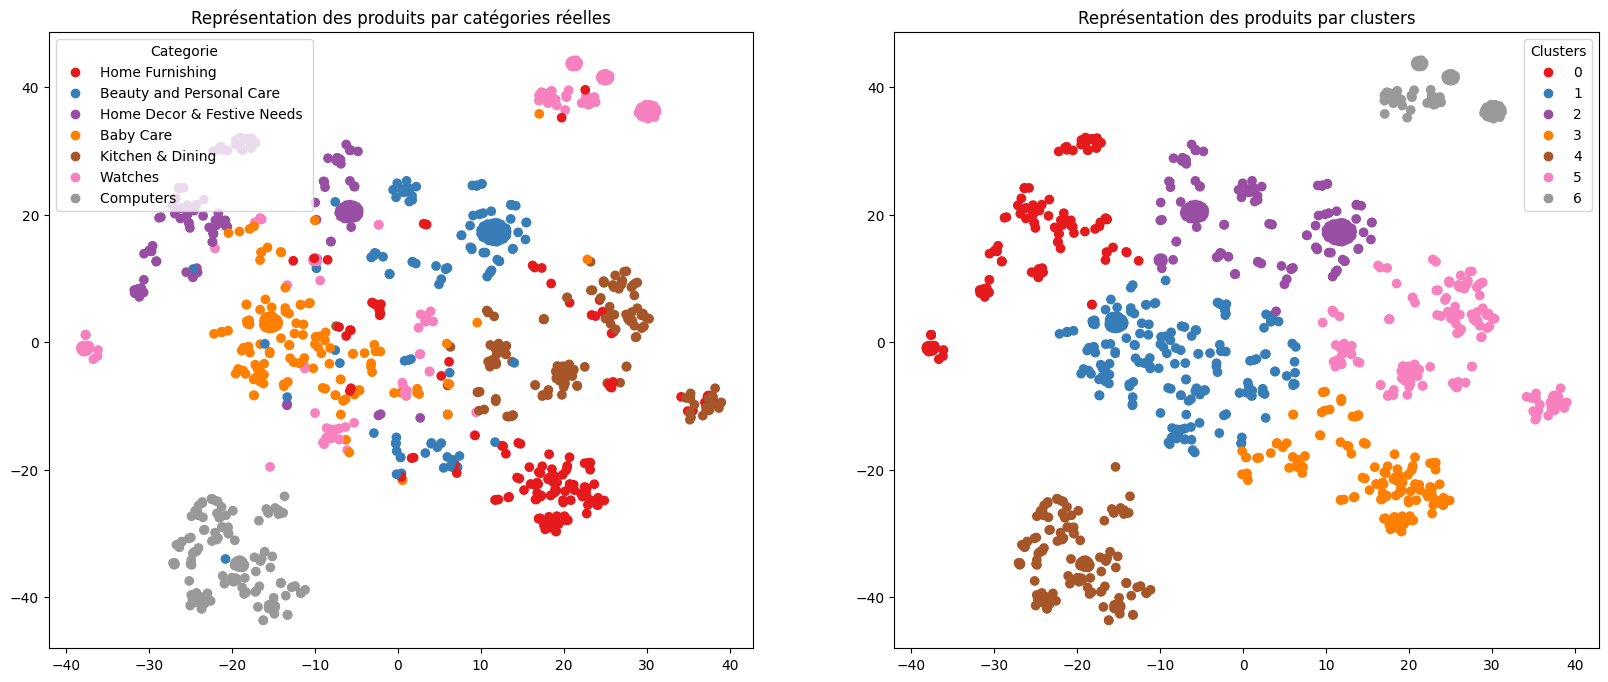


📊 Résultats ARI :
  Vectorizer Réduction                 ARI
0     TF-IDF      TSNE  0.5561036950210557


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def reduc_visu_fct(reduc_X, target, labels):
    """visualisation des axes réduits (2 premiers) selon les vraies catégories et selon les clusters"""
    # Encodage des targets pour la couleur des clusters
    label_encoder = LabelEncoder()
    y_categ = label_encoder.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()

# 📌 Initialisation du tableau des résultats ARI
ARI_results = np.empty((0, 3), dtype=object)

# ✅ Étape 1 : Vectorisation avec TF-IDF
vectorizer_tfidf = TfidfVectorizer(stop_words="english", min_df=0.01, max_df=0.95)
tfidf_features = vectorizer_tfidf.fit_transform(data["cleaned_description"])

# Nombre de clusters à utiliser
nb_clusters = len(data["catA"].unique())

# ✅ Étape 2 : KMeans sur les données vectorisées
X_reduc_tsne = reduction_fct(tfidf_features, method="TSNE")
ARI, labels = kmeans_fct(X_reduc_tsne, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_tsne, data["catA"], labels)
ARI_results = np.append(ARI_results, [["TF-IDF", "TSNE", ARI]], axis=0)

# 📌 Affichage des résultats ARI finaux
print("\n📊 Résultats ARI :")
print(pd.DataFrame(ARI_results, columns=["Vectorizer", "Réduction", "ARI"]))

In [50]:
# Importation des bibliothèques
from keras.applications import EfficientNetB3
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input

from PIL import Image, ImageOps
from tqdm import tqdm  # Pour afficher la barre de progression
import warnings

warnings.simplefilter('ignore', Image.DecompressionBombWarning)

# Dossier contenant les images
IMAGE_DIR = "./Flipkart/Images/"

# Chargement de la liste des images
from os import listdir

list_photos = [file for file in listdir(IMAGE_DIR)]

# Initialisation du tableau X (images prétraitées)
X = []

# Parcours de toutes les images
for image_num in tqdm(range(len(list_photos))):
    # Charger l'image
    img = load_img(IMAGE_DIR + data["image"][image_num], target_size=(300, 300))  # EfficientNet attend du 300x300

    # Appliquer l'égalisation de l'histogramme
    img = ImageOps.equalize(img, mask=None)

    # Convertir en tableau NumPy
    img = np.array(img)

    # Reshape pour correspondre aux attentes du modèle
    reshaped_img = img.reshape(300, 300, 3)

    # Prétraitement spécifique à EfficientNet
    imgx = preprocess_input(reshaped_img)

    # Ajouter à la liste des images
    X.append(imgx)

# Convertir X en numpy array
X = np.array(X)

# Charger EfficientNetB3 pré-entraîné sur ImageNet
EfficientNetB3_model = EfficientNetB3(weights="imagenet")

# Modifier le modèle pour extraire les features de la dernière couche avant classification
EfficientNetB3_model = Model(inputs=EfficientNetB3_model.inputs,
                             outputs=EfficientNetB3_model.layers[-2].output)  # Avant la couche softmax

# Générer les features
effinet_features = EfficientNetB3_model.predict(X,  batch_size=32)

# Afficher la forme des features extraits
print("Features extraits (shape) :", effinet_features.shape)

  0%|          | 0/1050 [00:00<?, ?it/s]

100%|██████████| 1050/1050 [00:21<00:00, 49.59it/s]
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1164']
Received: inputs=Tensor(shape=(32, 300, 300, 3))
  warnings.warn(msg)


32/33 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1164']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)


33/33 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step
Features extraits (shape) : (1050, 1536)


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Réduction de dimension avec TSNE
ARI : 0.5275


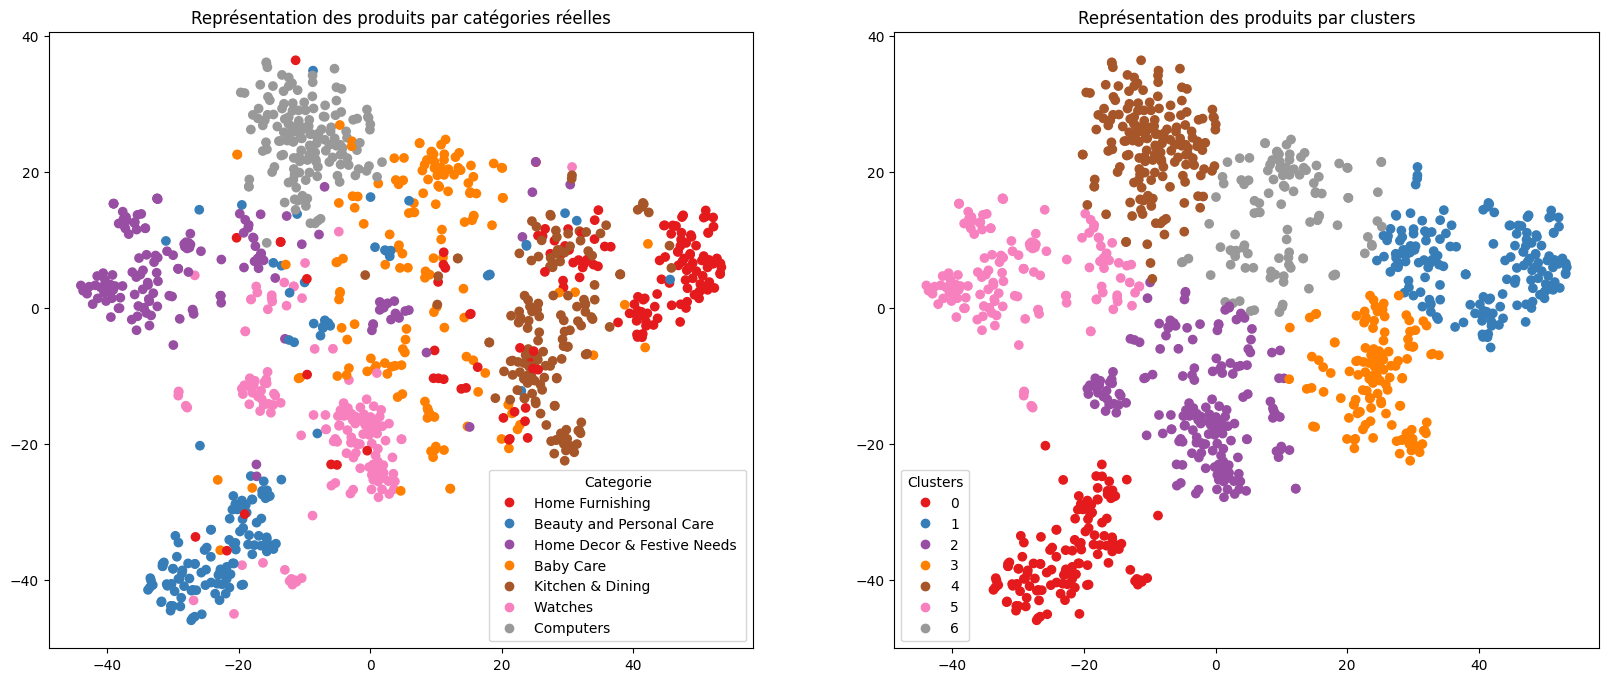

In [51]:
# TSNE + kmeans

X_reduc = reduction_fct(effinet_features, method='TSNE')
ARI, labels = kmeans_fct(X_reduc, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc, data["catA"], labels)

ARI_results = np.append(ARI_results, [["EfficientNetB3", "TSNE", ARI]], axis=0)

In [52]:
# Convertir la matrice sparse en un tableau NumPy dense
tfidf_features = tfidf_features.toarray()

feat_tfidf_effinet = np.concatenate((tfidf_features, effinet_features), axis=1)

print("Concaténation réussie ! Shape finale :", feat_tfidf_effinet.shape)


Concaténation réussie ! Shape finale : (1050, 1964)


/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Réduction de dimension avec TSNE
ARI : 0.5505


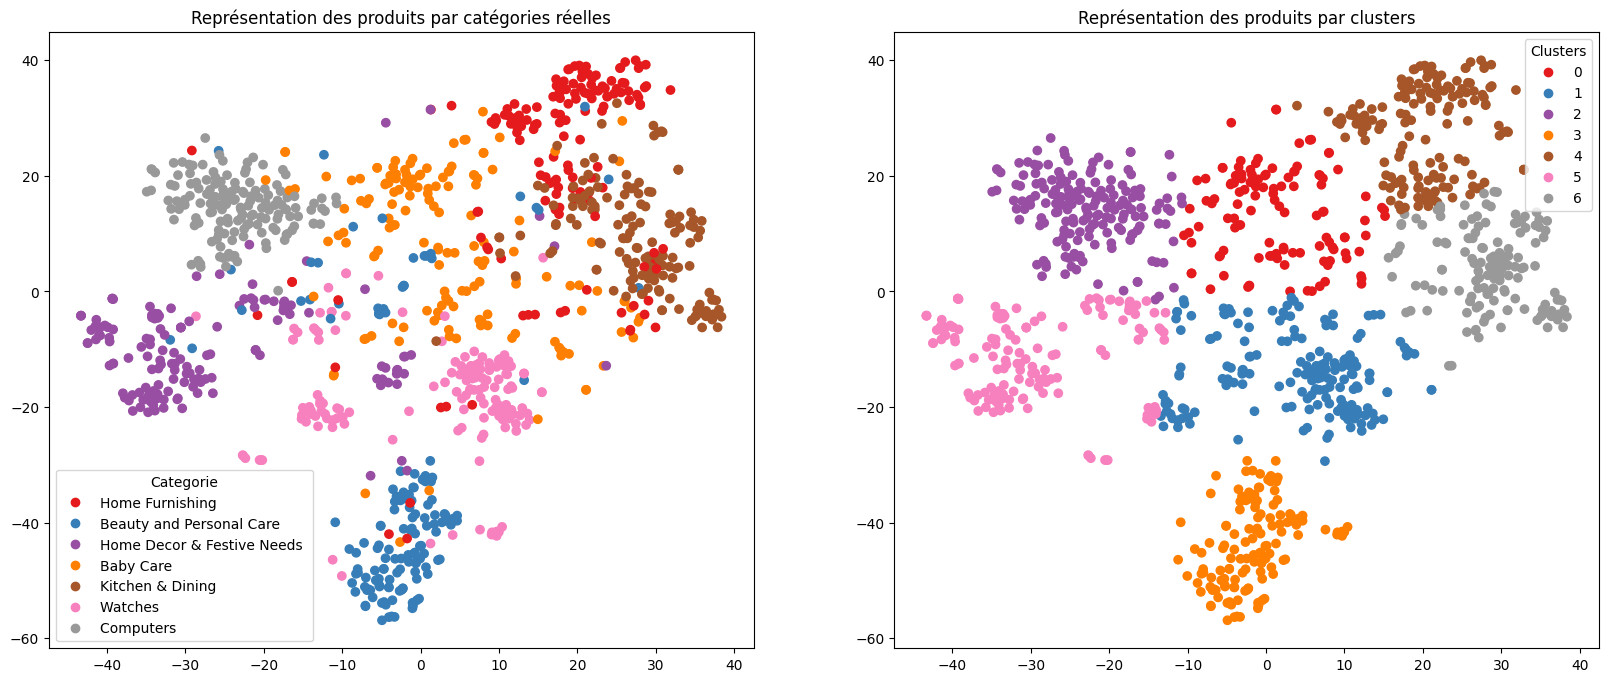

In [53]:
X_reduc = reduction_fct(feat_tfidf_effinet, method='TSNE')
ARI, labels = kmeans_fct(X_reduc, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc, data["catA"], labels)

ARI_results = np.append(ARI_results, [["EfficientNetB3_TFIDF", "TSNE", ARI]], axis=0)

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
feat_tfidf_effinet_scaled = scaler.fit_transform(feat_tfidf_effinet)

Dimensions avant SVD : 1964
Dimensions après SVD (99% var. explained): 100
ARI : 0.4908


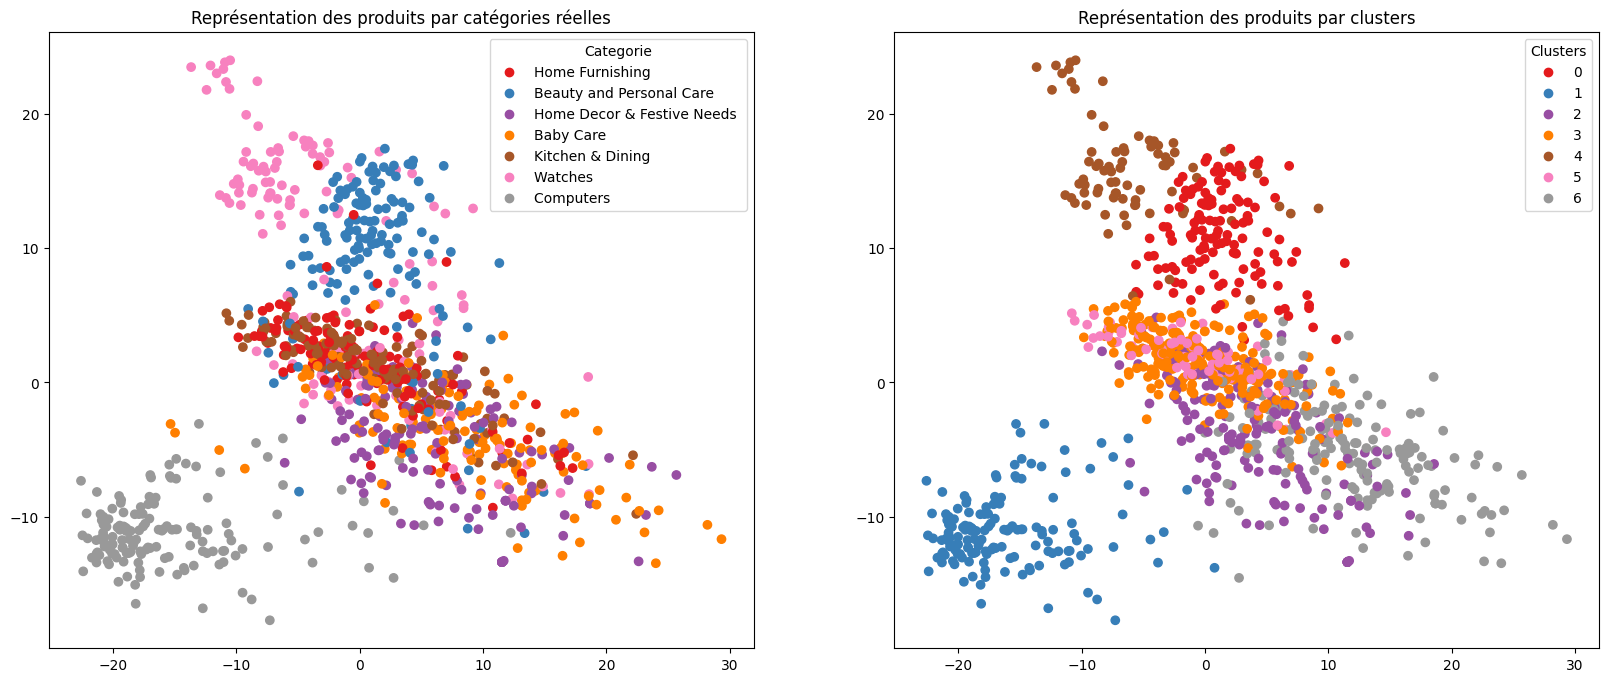

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Réduction de dimension avec UMAP
ARI : 0.4083


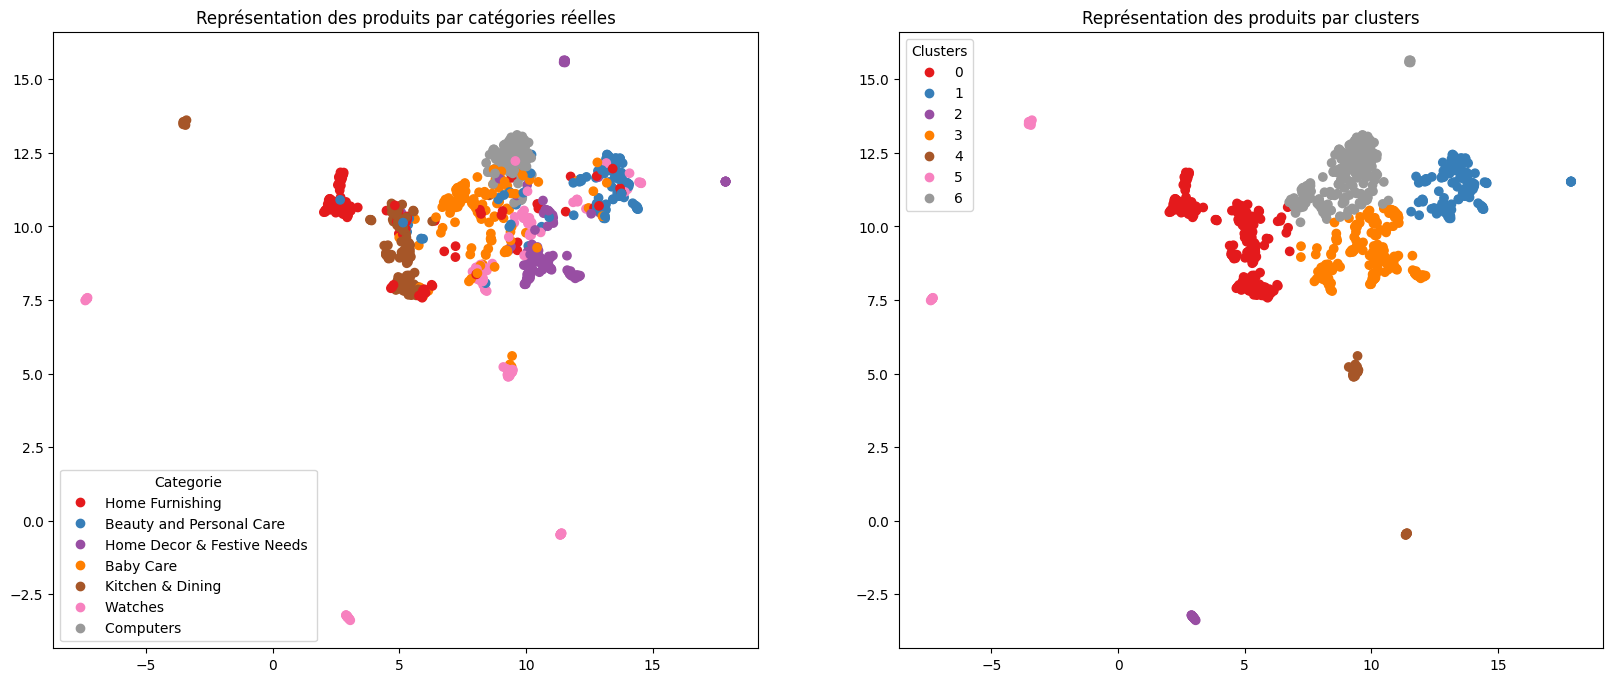

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Réduction de dimension avec TSNE
ARI : 0.5417


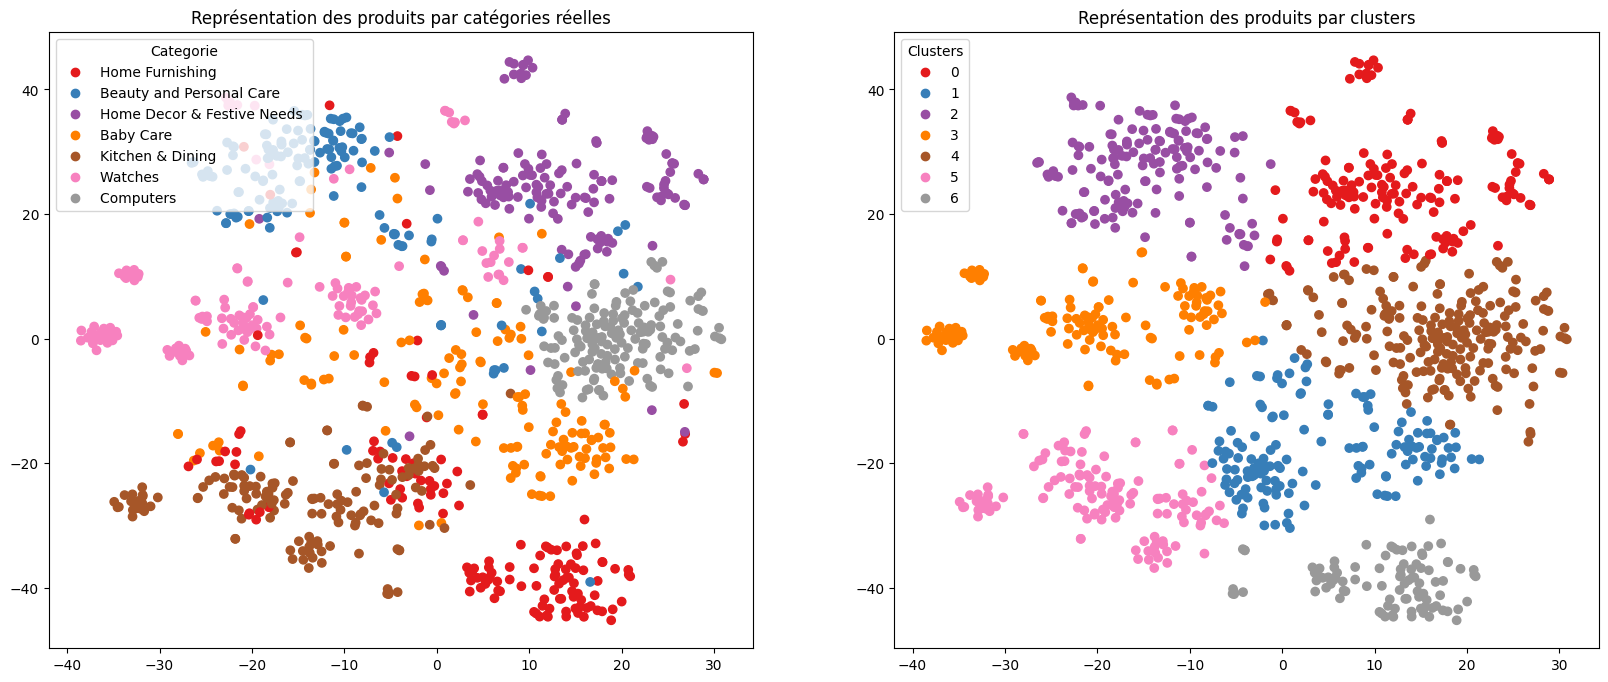

In [55]:
# Réduction SVD + KMeans
X_reduc = reduction_fct(feat_tfidf_effinet_scaled, method='SVD')
ARI, labels = kmeans_fct(X_reduc, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc, data["catA"], labels)
ARI_results = np.append(ARI_results, [["EfficientNetB3_TFIDF_scaled", "SVD", ARI]], axis=0)

# Réduction UMAP + KMeans
X_reduc_umap = reduction_fct(feat_tfidf_effinet_scaled, method="UMAP")
ARI, labels = kmeans_fct(X_reduc_umap, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_umap, data["catA"], labels)
ARI_results = np.append(ARI_results, [["EfficientNetB3_TFIDF_scaled", "UMAP", ARI]], axis=0)

#Réduction TSNE + KMeans
X_reduc_tsne = reduction_fct(feat_tfidf_effinet_scaled, method="TSNE")
ARI, labels = kmeans_fct(X_reduc_tsne, data["catA"], nb_clusters)
reduc_visu_fct(X_reduc_tsne, data["catA"], labels)
ARI_results = np.append(ARI_results, [["EfficientNetB3_TFIDF_scaled", "TSNE", ARI]], axis=0)

/Users/gillestellier/opt/anaconda3/envs/ocr_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


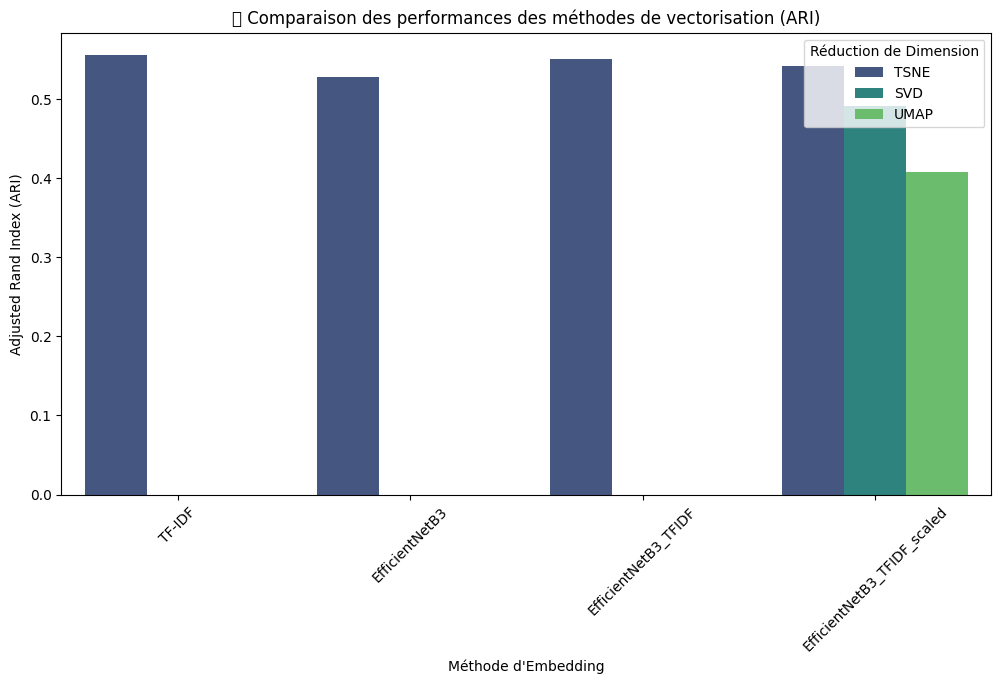

In [56]:
import seaborn as sns

df_ari_results = pd.DataFrame(
    ARI_results, columns=["Modèle", "Réduction", "ARI"])
df_ari_results['ARI'] = df_ari_results['ARI'].astype(float)

# 📌 Visualisation des scores ARI
plt.figure(figsize=(12, 6))
sns.barplot(data=df_ari_results, x="Modèle", y="ARI", hue="Réduction", palette="viridis")

plt.ylabel("Adjusted Rand Index (ARI)")
plt.xlabel("Méthode d'Embedding")
plt.title("📊 Comparaison des performances des méthodes de vectorisation (ARI)")
plt.xticks(rotation=45)
plt.legend(title="Réduction de Dimension")

plt.show()

Meilleurs hyperparamètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Score moyen en validation croisée : 0.9202

Matrice de confusion brute :
[[24  0  0  2  4  0  0]
 [ 0 24  0  6  0  0  0]
 [ 0  0 29  0  1  0  0]
 [ 1  0  0 27  1  1  0]
 [ 1  0  0  0 29  0  0]
 [ 0  0  0  1  0 29  0]
 [ 0  0  0  0  0  0 30]]


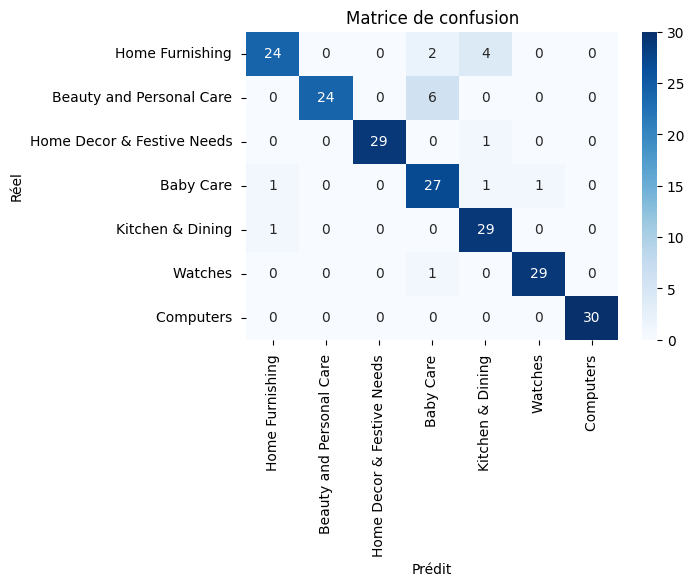


Rapport de classification :
                             precision    recall  f1-score   support

                 Baby Care        0.92      0.80      0.86        30
  Beauty and Personal Care        1.00      0.80      0.89        30
                 Computers        1.00      0.97      0.98        30
Home Decor & Festive Needs        0.75      0.90      0.82        30
           Home Furnishing        0.83      0.97      0.89        30
          Kitchen & Dining        0.97      0.97      0.97        30
                   Watches        1.00      1.00      1.00        30

                   accuracy                           0.91       210
                  macro avg       0.92      0.91      0.92       210
               weighted avg       0.92      0.91      0.92       210



In [57]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = tfidf_features
y = data['catA']

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Définition du modèle avec recherche d'hyperparamètres
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_model = grid_search.best_estimator_
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")

# Validation croisée
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Score moyen en validation croisée : {cv_scores.mean():.4f}")

# Prédictions sur le test set
predictions = best_model.predict(X_test)

# Matrice de confusion
conf_mat = metrics.confusion_matrix(y_test, predictions)
print("\nMatrice de confusion brute :")
print(conf_mat)

# Affichage de la matrice de confusion
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=set(y), yticklabels=set(y))
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# Rapport de classification
print("\nRapport de classification :")
print(metrics.classification_report(y_test, predictions))